# Jun ??st, 2022 (Cartography figure)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.bootstrap import *
from analysis.network import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Prepare (128)

In [2]:
mice = Mice(128)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [3]:
task = 'rest'
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

num_k, p = 7, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

bt_ca = BootStrap(**props_ca)
bt_bo = BootStrap(**props_bo)

## How mu = 0.003, alpha = 0.05 looks: raw vs. prune

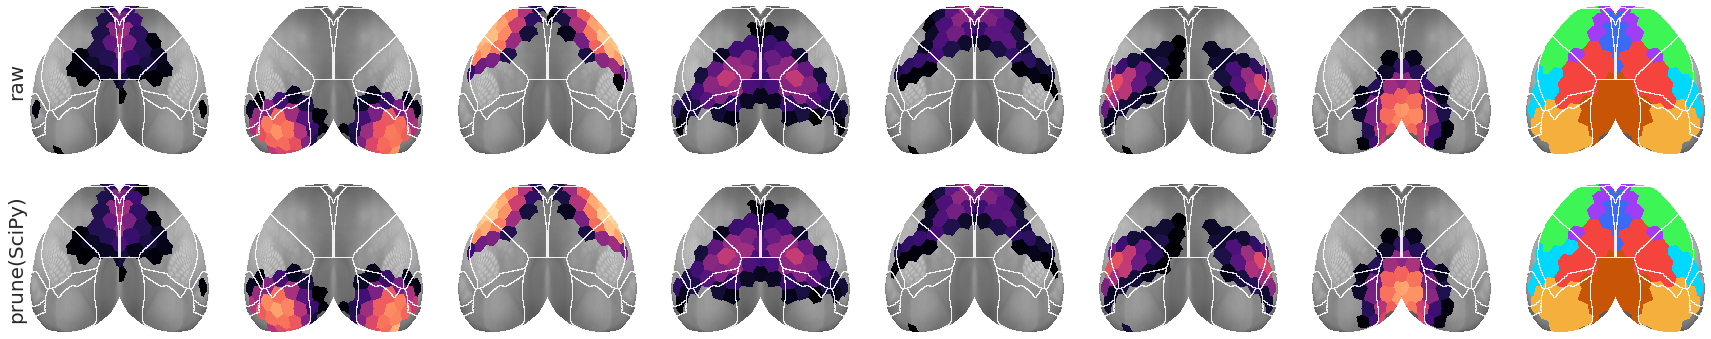

In [4]:
_ = bt_ca.show(
    data={'raw': avg(bt_ca.run_pi), 'prune(SciPy)': avg(bt_ca.pi_prune)},
    figsize=(30, 6),
    ylabel_fontsize=20,
)

In [5]:
[e[-1] for e in bt_ca.pi_symmetry_score(avg(bt_ca.pi_prune))]

[0.991, 0.985]

In [6]:
[e[-1] for e in bt_ca.pi_symmetry_score(avg(bt_ca.run_pi))]

[0.992, 0.989]

## Members: various $\mu$

In [7]:
se, f = bt_ca.fit_boot(n_resamples=int(1e6))
f

'se-BCa_group-pi_1.0e+06'

In [8]:
pi = avg(bt_ca.pi_prune)
members = np.zeros(pi.shape)
alpha = 0.05

mu_vals = [0.05] + [i / bt_ca.num_k for i in [1, 2, 3]]
for mu in mu_vals:
    reject, pvals = bt_ca.ttest(se, pi, mu=mu, alpha=alpha)
    members[reject == 1] += 1
members /= np.nanmax(members)

mu_vals

[0.05, 0.14285714285714285, 0.2857142857142857, 0.42857142857142855]

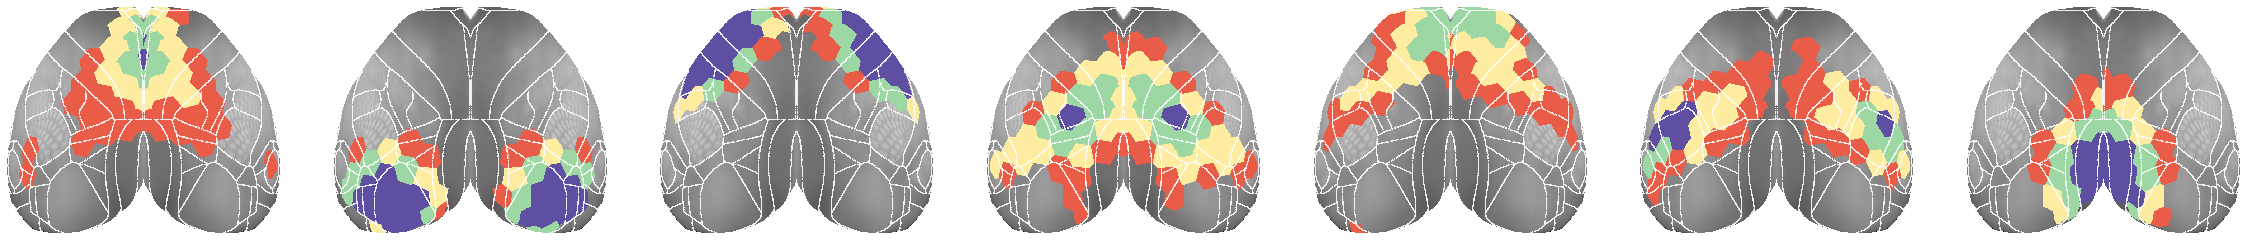

In [9]:
_ = bt_ca.show(
    data=members.astype(float),
    vmin=0.1,
    vmax=1.0,
    cmap='Spectral',
    coarse=False,
    width=0.001,
    add_disjoint=False,
    figsize=(40, 8),
)

## Finally, carto

In [10]:
def plot_cartography(
    df: pd.DataFrame,
    palette: Dict[str, str],
    xlim: Tuple[float, float] = None,
    ylim: Tuple[float, float] = None,
    hue: str = 'oc_idx',
    grid: bool = True,
    display: bool = True,
    leg_size: float = 14,
    size: float = 7,
    scatter_kws: dict = None,
    density_kws: dict = None,
    median_kws: dict = None, ):
    
    scatter_kws = scatter_kws if scatter_kws else {
        's': 120,
        'alpha': 0.9,
        'edgecolor': 'dimgrey',
    }
    density_kws = density_kws if density_kws else {
        'lw': 2,
        'fill': True,
        'alpha': 0.5,
    }
    median_kws = median_kws if median_kws else {
        'lw': 1.5,
        'ls': '--',
        'zorder': 0,
        'alpha': 1.0,
        'c': sns.color_palette('deep')[7],
    }
    
    set_style('ticks')
    jg = sns.JointGrid(
        data=df,
        x='entropy',
        y='degree',
        hue=hue,
        size=size,
        palette=palette,
        xlim=xlim,
        ylim=ylim,
        space=0.0,
    )
    # joint: scatter
    jg.plot_joint(
        sns.scatterplot,
        hue=hue,
        **scatter_kws,
    )
    # margnials: density
    jg.plot_marginals(
        sns.kdeplot,
        **density_kws,
    )
    # medians
    for name in ['entropy', 'degree']:
        x = df[name].median()
        lbl = f"median {name}: {x:.2f}"
        if name == 'entropy':
            jg.refline(x=x, label=lbl, **median_kws)
        else:
            jg.refline(y=x, label=lbl, **median_kws)
    # legend
    jg.ax_joint.legend(loc='upper left', prop={'size': leg_size})
    leg = jg.ax_joint.get_legend()
    if leg is not None:
        plt.setp(leg, bbox_to_anchor=(1.3, 1.0))
    
    if grid:
        jg.ax_joint.grid()
    
    if display:
        plt.show()
    else:
        plt.close()
    return jg

In [11]:
df = bt_ca.mk_cartography_df()

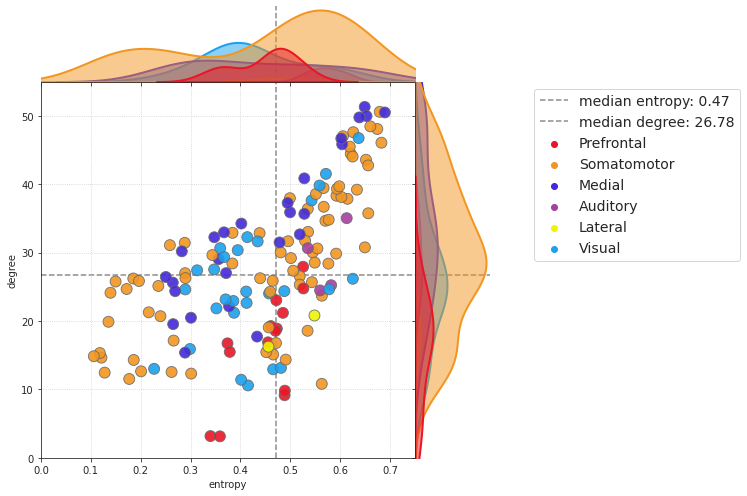

In [12]:
xlim = (0, 0.75)
ylim = (0, 55)

jg = plot_cartography(
    df=df,
    palette=bt_ca.affil['colors'],
    hue='affil',
    xlim=xlim,
    ylim=ylim,
    grid=True,
)

In [13]:
pi = bn.nanmean(bt_ca.pi_prune, -3)
ent = sp_stats.entropy(pi, axis=-2) / np.log(pi.shape[-2])

In [14]:
x = np.concatenate([
    np.expand_dims(ent, -2),
    np.expand_dims(bt_ca.run_deg, -2),
], axis=-2)
x.shape

(10, 3, 4, 2, 152)

In [15]:
se_carto = bt_ca.get_booter(int(1e5))(x)
se_carto.shape

(2, 152)

<AxesSubplot:ylabel='Count'>

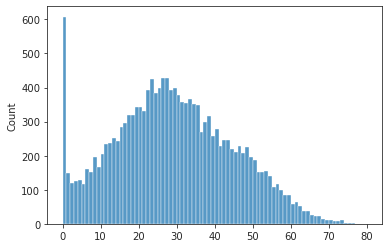

In [16]:
sns.histplot(bt_ca.run_deg.ravel(), bins=np.linspace(0, 80, 81))

In [17]:
ci, dof = 0.95, 9
whis = np.round((1 + ci) / 2, 5)
tval = sp_stats.t.ppf(whis, dof)

tval

2.2621571627409915

In [18]:
vlines = [df['entropy'].quantile(q) for q in [0.25, 0.5, 0.75]]
hlines = [df['degree'].quantile(q) for q in [0.25, 0.5, 0.75]]

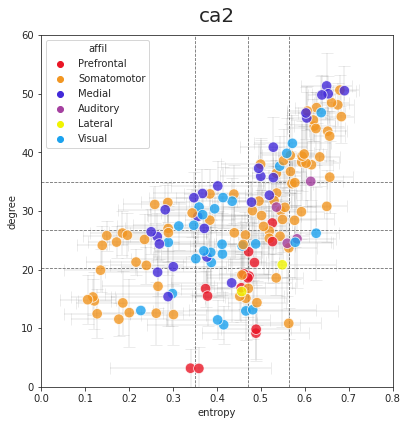

In [19]:
fig, ax = create_figure(1, 1, (8, 6), 'all', 'all')

for x in vlines:
    ax.axvline(x, color='dimgrey', ls='--', lw=0.8, zorder=0)
for y in hlines:
    ax.axhline(y, color='dimgrey', ls='--', lw=0.8, zorder=0)

sns.scatterplot(
    data=df,
    x='entropy',
    y='degree',
    hue='affil',
    palette=bt_ca.affil['colors'],
    s=110,
    alpha=0.8,
    ax=ax,
)
ax.set_title('ca2', fontsize=20, y=1.02)

ax.errorbar(
    x=df['entropy'].values,
    y=df['degree'].values,
    xerr=tval * se_carto[0],
    yerr=tval * se_carto[1],
    color='dimgrey',
    errorevery=1,
    capsize=6,
    alpha=0.12,
    ls='none',
    zorder=0,
)

xlim = (0, 0.8)
ylim = (0, 60)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
aspect = (max(xlim) - min(xlim)) / (max(ylim) - min(ylim))
ax.set_aspect(aspect, adjustable='box')
# name = 'carto-group'
# figname = f"{name}.pdf"
# fig.savefig(pjoin(save_dir, figname), **fig_kws)


plt.show()

In [20]:
df = bt_bo.mk_cartography_df()

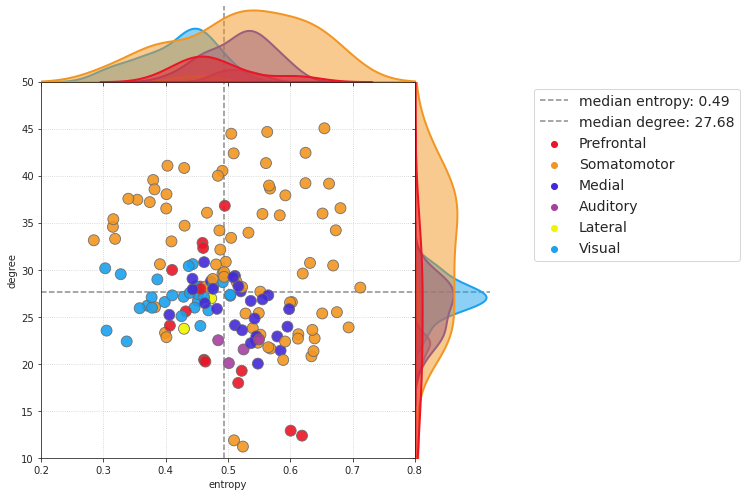

In [21]:
xlim = (0.2, 0.8)
ylim = (10, 50)

jg = plot_cartography(
    df=df,
    palette=bt_ca.affil['colors'],
    hue='affil',
    xlim=xlim,
    ylim=ylim,
    grid=True,
)

In [23]:
pi = bn.nanmean(bt_bo.pi_prune, -3)
ent = sp_stats.entropy(pi, axis=-2) / np.log(pi.shape[-2])

In [24]:
x = np.concatenate([
    np.expand_dims(ent, -2),
    np.expand_dims(bt_bo.run_deg, -2),
], axis=-2)
x.shape

(10, 3, 4, 2, 152)

In [25]:
se_carto = bt_bo.get_booter(int(1e5))(x)
se_carto.shape

(2, 152)

<AxesSubplot:ylabel='Count'>

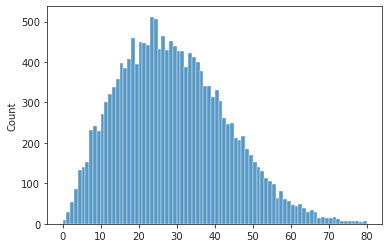

In [26]:
sns.histplot(bt_bo.run_deg.ravel(), bins=np.linspace(0, 80, 81))

In [27]:
ci, dof = 0.95, 9
whis = np.round((1 + ci) / 2, 5)
tval = sp_stats.t.ppf(whis, dof)

tval

2.2621571627409915

In [28]:
vlines = [df['entropy'].quantile(q) for q in [0.25, 0.5, 0.75]]
hlines = [df['degree'].quantile(q) for q in [0.25, 0.5, 0.75]]

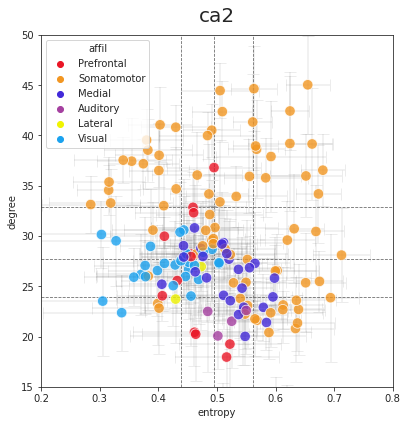

In [35]:
fig, ax = create_figure(1, 1, (8, 6), 'all', 'all')

for x in vlines:
    ax.axvline(x, color='dimgrey', ls='--', lw=0.8, zorder=0)
for y in hlines:
    ax.axhline(y, color='dimgrey', ls='--', lw=0.8, zorder=0)

sns.scatterplot(
    data=df,
    x='entropy',
    y='degree',
    hue='affil',
    palette=bt_bo.affil['colors'],
    s=110,
    alpha=0.8,
    ax=ax,
)
ax.set_title('ca2', fontsize=20, y=1.02)

ax.errorbar(
    x=df['entropy'].values,
    y=df['degree'].values,
    xerr=tval * se_carto[0],
    yerr=tval * se_carto[1],
    color='dimgrey',
    errorevery=1,
    capsize=6,
    alpha=0.12,
    ls='none',
    zorder=0,
)

xlim = (0.2, 0.8)
ylim = (15, 50)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
aspect = (max(xlim) - min(xlim)) / (max(ylim) - min(ylim))
ax.set_aspect(aspect, adjustable='box')
# name = 'carto-group'
# figname = f"{name}.pdf"
# fig.savefig(pjoin(save_dir, figname), **fig_kws)


plt.show()